# Islanding detection based on CNN
In this notebook, convolutional neural networks are used in order to detect islanding events extracted from a Matlab/Simulink simulation. The dataset was gathered using a 100kW grid-connected photovoltaic system based on https://www.mathworks.com/help/physmod/sps/ug/detailed-model-of-a-100-kw-grid-connected-pv-array.html. The diagram of the model can be seen in the next image:

![Title](img/simulink_model_pic.png)


The dataset was constructed by changing the active power of a Load connected at the point of common coupling from values between 90kW and 110kW. First, the voltage at each phase in the point of common coupling was measured and concatenated in a single array. Then, this time-series data was  converted into images using the wavelet tranform with a Morlet wavelet. This images were then rescaled to an RGB image of 224x224 pixels,  generating the dataset used for this project. Each event in the dataset was generated at time 0.2s in the simulation. The voltage used was measured between seconds 0.2s and 0.35s. The sample rate for the data generated was 2e-05s. The scenarios included in the dataset can be seen in the following table:

| - |Grid-connected C_ON|Grid-connected C_OFF|Sudden swithcing OFF C|Sudden switching ON C| Islanding event C_ON  | Islanding event C_OFF | LL-fault | LN-fault | Total |
|---| --- | --- | --- | --- | --- |--- |--- | --- | --- |
| # Events | 100 | 100 | 100 | 100 | 100 |  100 | 100 | 100 | 800 |
| Label | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | --- |


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In the next cell, several images from the different scenarios in the dataset collected are ploted. As it can be seen, many of the images seem to be the same when they are not.

In [ ]:
f, axarr = plt.subplots(4,2, figsize=(20,20))
images = os.listdir("./img/graphs")
counter = 0
for a in range(len(axarr)):
    for b in range(len(axarr[a])):
        img = image.load_img("./img/graphs/" + images[counter])
        axarr[a,b].axis('off')
        axarr[a,b].imshow(img)
        axarr[a,b].set_title(images[counter][:images[counter].find(".png")])
        counter += 1

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:
def graficarMatrizConfusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]  

    plt.figure(figsize=(8,8))

    ax = sns.heatmap(cm, annot = True, cbar = False);
      
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
      
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confussion Matrix")
    plt.savefig('img/Confussion_matrix.png')
    plt.show()


The next cell extracts the dataset from the .mat file generated. Each image had a size of (224, 224, 3). The dataset is composed of three columns, the first column corresponds to the value of the load at the moment of generating the the data, the second column corresponds to the image generated from the wavelet transform and the thrid column has the label of the data selected.

In [ ]:
from scipy.io import loadmat
import numpy as np
import h5py
filename = "dataset_IDM.mat"
with h5py.File(filename, 'r') as f:
    ref_label = np.array(f['dataset']['label'])
    labels = np.array([int(np.array(f[f['dataset']['label'][i][0]]).squeeze()) for i in range(0, len(ref_label))])
    images = np.array([np.array(f[f['dataset']['data'][i][0]]).squeeze() for i in range(0, len(ref_label))]).reshape(-1,224,224,3)

Next, we plot the data from matlab converted to RGB images (this is how they are saved in the dataset):

In [ ]:
import matplotlib.image as mpimg
from PIL import Image
f, axarr = plt.subplots(4,2, figsize=(20,20))
def labels_names(argument):
    switcher = {
        0: "Grid-connected C_ON",
        1: "Grid connected C_OFF",
        2: "Sudden switching OFF C",
        3: "Sudden switching ON C",
        4: "Islanding event C_ON",
        5: "Islanding event C_OFF",
        6: "LL-Fault",
        7: "LN-Fault",
    }
    return switcher.get(argument, "Invalid month")
index = 99
for a in range(len(axarr)):
    for b in range(len(axarr[a])):
        axarr[a,b].axis('off')
        axarr[a,b].imshow(np.clip(images[index], 0, 1)) 
        axarr[a,b].set_title(labels_names(labels[index]))
        index+= 100


We proceed to separate the dataset between training and testing values in the next cell.

In [ ]:
np.random.seed(seed=42)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.33, random_state = 42)

In [11]:
np.save("test_data.npy", x_test)
np.save("test_labels.npy", y_test)

### Convolutional Neural Network Model
The architecture of the CNN is presented in the next code:

In [58]:
tf.random.set_seed(51)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape = (224, 224, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(8, activation='softmax')
    ])
model.summary()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 43264)            

In [59]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('val_sparse_categorical_accuracy') == 1):
            print('\n Maximum validation accuracy reached, stopping training')
            self.model.stop_training = True
callbacks = myCallback()
model.fit(x_train, 
          y_train,
          validation_data = (x_test, y_test),
          epochs = 85,
          verbose = 1,
          callbacks = [callbacks])

Epoch 1/85
17/17 [==============================] - 1s 57ms/step - loss: 2.0110 - sparse_categorical_accuracy: 0.2349 - val_loss: 1.4176 - val_sparse_categorical_accuracy: 0.6515
Epoch 2/85
17/17 [==============================] - 1s 40ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.5977 - val_loss: 0.7863 - val_sparse_categorical_accuracy: 0.7992
Epoch 3/85
17/17 [==============================] - 1s 39ms/step - loss: 0.8082 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.8280 - val_sparse_categorical_accuracy: 0.6591
Epoch 4/85
17/17 [==============================] - 1s 41ms/step - loss: 0.7927 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.7045
Epoch 5/85
17/17 [==============================] - 1s 41ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.4971 - val_sparse_categorical_accuracy: 0.7462
Epoch 6/85
17/17 [==============================] - 1s 41ms/step - loss: 0.6046 - sparse_categorical_accu

17/17 [==============================] - 1s 41ms/step - loss: 0.2605 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.2419 - val_sparse_categorical_accuracy: 0.8523
Epoch 46/85
17/17 [==============================] - 1s 41ms/step - loss: 0.2257 - sparse_categorical_accuracy: 0.8819 - val_loss: 0.2040 - val_sparse_categorical_accuracy: 0.9053
Epoch 47/85
17/17 [==============================] - 1s 41ms/step - loss: 0.2437 - sparse_categorical_accuracy: 0.8677 - val_loss: 0.3561 - val_sparse_categorical_accuracy: 0.8523
Epoch 48/85
17/17 [==============================] - 1s 40ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.2850 - val_sparse_categorical_accuracy: 0.8523
Epoch 49/85
17/17 [==============================] - 1s 41ms/step - loss: 0.3230 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.3470 - val_sparse_categorical_accuracy: 0.8523
Epoch 50/85
17/17 [==============================] - 1s 40ms/step - loss: 0.2637 - sparse_categorical_accuracy: 

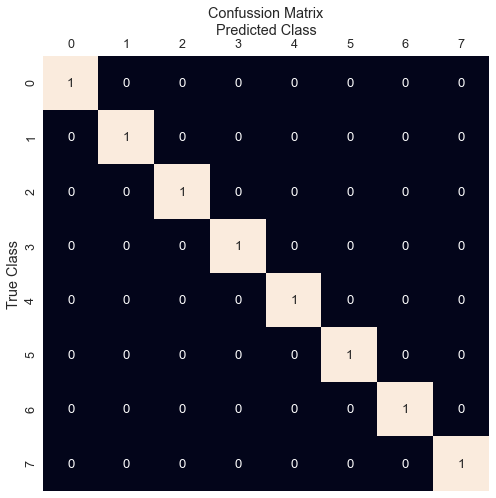

In [64]:
graficarMatrizConfusion(y_true = y_train, y_pred = np.argmax(model.predict(x_train),axis=1))

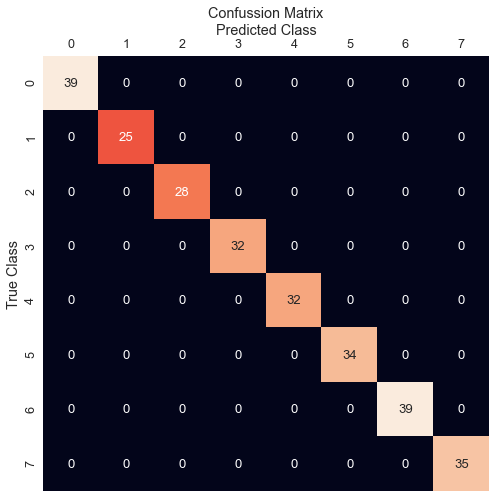

In [67]:
graficarMatrizConfusion(y_true = y_test, y_pred = np.argmax(model.predict(x_test),axis=1))

In [62]:
model.save('model/islanding_model.h5')